In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import pickle

#Matplotlib styles
%config InlineBackend.figure_format='retina'
plt.style.use(["science", "notebook"])

plt.rcParams["legend.fancybox"] = False
plt.rcParams["legend.frameon"] = True
plt.rcParams["legend.edgecolor"] = "black"
plt.rcParams["legend.fontsize"] = 13
plt.rcParams["legend.framealpha"] = 1

plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12

plt.rcParams["axes.labelsize"] = 14
plt.rcParams["axes.titlesize"] = 17
plt.rcParams["axes.grid"] = True

plt.rcParams["grid.color"] = "gray"
plt.rcParams["grid.linestyle"] = (1, (4, 9))


In [2]:
def ordered_degree_list(G):
    """
    Ordenar nodos por grado (de mayor a menor).
    """
    deg = list(G.degree())
    deg.sort(key = lambda x: x[1], reverse = True)
    return [n for (n, d) in deg]

def order_dict_by_val(d):
    """
    Ordenar diccionario por valor.
    """
    return [k for k, v in sorted(d.items(), key=lambda x: x[1], reverse=True)]

def giant_component(G):
    """
    Obtiene la componente gigante de una red.
    """
    try:
        nodes_in_giant = max(nx.connected_components(G), key=len)
    except ValueError:
        raise ValueError("No existe componente gigante")

    gc = G.subgraph(nodes_in_giant).copy()
    return gc

In [3]:
#Carga de DataFrames
df_y2h = pd.read_csv("datasets/yeast_Y2H.txt", delimiter = "\t", header = None, names = ["source", "target"])
df_apms = pd.read_csv("datasets/yeast_AP-MS.txt", delimiter = "\t", header = None, names = ["source", "target"])
df_lit = pd.read_csv("datasets/yeast_LIT.txt", delimiter = "\t", header = None, names = ["source", "target"])
df_litreg = pd.read_csv("datasets/yeast_LIT_Reguly.txt", delimiter = "\t")
df_litreg_mod = df_litreg.rename(columns = {"Bait gene/protein": "source", "Hit gene/protein": "target"})[["source", "target"]]

#Carga de Redes
graph_y2h = nx.from_pandas_edgelist(df_y2h)
graph_apms = nx.from_pandas_edgelist(df_apms)
graph_lit = nx.from_pandas_edgelist(df_lit)
graph_litreg = nx.from_pandas_edgelist(df_litreg_mod)

nets = {"Y2H": graph_y2h, "AP-MS": graph_apms, 
        "LIT": graph_lit, "LIT-Reguly": graph_litreg}

In [4]:
#Carga y modificación de Essential_ORFs_paperHe.txt

def parse_list(x):
    splitted = x.split(",")
    if len(splitted) == 1 and splitted[0] == "":
        return None
    return splitted

def remove_spaces(x):
    removed = x.replace(" ", "")
    if removed == "":
        return None
    return removed

ess = pd.read_csv("datasets/Essential_ORFs_paperHe.txt", delimiter="\t")
ess.drop(0, inplace=True) #Eliminamos los guiones.
ess.where(pd.notnull(ess), None, inplace=True) #Reemplaza los NaNs de numpy con Nones
ess.rename(columns = {"gene_names                                           ": "gene_names"}, inplace = True)

#Quitamos espacios innecesarios
ess["gene_names"] = ess["gene_names"].dropna().apply(remove_spaces)
ess["deletion_alias"] = ess["deletion_alias"].dropna().apply(remove_spaces)

#Parseamos listas
ess["gene_names"] = ess["gene_names"].dropna().apply(parse_list)


ess["ORF_name"] = ess["ORF_name"].dropna().apply(lambda x: x.replace(" ", "").upper())
ess_names = list(ess["ORF_name"].dropna().unique()) #Lista de nodos esenciales

display(ess.head(5))
print(ess_names[:5])

,rec_num,ORF_name,deletion_alias,gene_names,UPTAG_sequence_20mer,DNTAG_sequence_20mer
1,20406,YAL001C,None,"[TSV115, FUN24]",ACTATATGTGAAGGCATGGC,None
2,20404,YAL003W,None,[TEF5],GACATATCAGCATACATGGC,None
3,20383,YAL025C,None,NaN,TGCCGCATCAAAGAGGCCAA,None
4,20376,YAL032C,None,[FUN20],TGATCCGCGTCGATGCTCTT,None
5,20375,YAL033W,None,[FUN53],CTGACTTAGTGCATACTGCT,None


['YAL001C', 'YAL003W', 'YAL025C', 'YAL032C', 'YAL033W']


# Tablas

## Tabla 1: Propiedades de las redes

In [6]:
nodes = {k: len(set(g.nodes)) for k, g in nets.items()}
edges = {k: len(set(g.edges)) for k, g in nets.items()}
mean_deg = {k: np.mean([d for n, d in list(graph_y2h.degree)]) for k, g in nets.items()}
avg_cc = {k: nx.average_clustering(g) for k, g in nets.items()}

tab1 = pd.DataFrame({"Nodos": nodes, "Enlaces": edges, "Grado medio": mean_deg, "Coef. Clustering medio": avg_cc})
display(tab1)

,Nodos,Enlaces,Grado medio,Coef. Clustering medio
Y2H,2018,2930,2.903865,0.046194
AP-MS,1622,9070,2.903865,0.554636
LIT,1536,2925,2.903865,0.292492
LIT-Reguly,3307,11858,2.903865,0.261134


## Tabla 2: Overlap entre redes

In [7]:
node_names = {k: set(g.nodes) for k, g in nets.items()}

#Calculo de overlap entre dos redes.
overlap = lambda nodes1, nodes2: len(nodes1.intersection(nodes2))/len(nodes2)
#Dada una red, calculo el overlap con las otras 3.
inter_dict = lambda net_name: {iter_name: overlap(node_names[net_name], iter_node_names) for iter_name, iter_node_names in node_names.items()}
#Consigo el diccionario anterior para las 4 redes.
intersections = {net_name: inter_dict(net_name) for net_name in nets.keys()}
tab2 = pd.DataFrame(intersections)
tab2

,Y2H,AP-MS,LIT,LIT-Reguly
Y2H,1.000000,0.357780,0.365709,0.658573
AP-MS,0.445129,1.000000,0.569667,0.877928
LIT,0.480469,0.601562,1.000000,0.985026
LIT-Reguly,0.401875,0.430602,0.457514,1.000000


## Tabla 3

In [45]:
from collections import Counter
from random import sample

#--------------------------------------------------------------------------------------------------------------------
### COLUMNA 1

def get_random_gc_frac(G):
    """
    Consigue la fracción de la componente gigante de una red G tras eliminar nodos
    con la misma distribución de grados que los nodos esenciales "ess_names".
    """
    global ess_names
    
    ### Conseguimos los nodos esenciales en la red, junto a su grado
    Gcopy = G.copy()
    degrees = dict(Gcopy.degree())
    nodes = list(Gcopy.nodes())
    #La lista toma los valores de los grados para el i-esimo nodo esencial, 
    # si está en la red. Despues armamos un contador para conocer la distribución. 
    ess_degree_dist = dict(Counter([degrees[n] for n in ess_names if n in nodes]))

    #Armamos un dict de la forma -> grado: [nombres de nodos con ese grado]
    nodes_by_degree = {}
    for i_degree in ess_degree_dist.keys():
        nodes_by_degree[i_degree] = [n for n, n_d in degrees.items() if n_d == i_degree]

    #Nos quedamos, para cada grado, la misma cantidad de nodos
    #aleatorios que los encontrados en ess_degree_dist.
    random_nodes = []
    for d in ess_degree_dist.keys():
        sampled_nodes = sample(nodes_by_degree[d], ess_degree_dist[d])
        assert len(sampled_nodes) == ess_degree_dist[d] #Sample debería evitar repetidos.
        random_nodes += sampled_nodes 
        
    gc_before = giant_component(Gcopy)
    Gcopy.remove_nodes_from(random_nodes) #Eliminamos los nodos alteatorios con la misma distribución que esenciales.
    gc_after = giant_component(Gcopy)
    
    return len(gc_after.nodes())/len(gc_before.nodes()) #Tamaño de la compontente gigante tras eliminar nodos / Tamaño inicial

try:
    raise Exception
    with open("random_fracs.dict","rb") as f:
        random_fracs = pickle.load(f)
except:
    #Ejecutamos el experimento 100 veces para cada red y calculamos la media.
    random_fracs = {net_name: [get_random_gc_frac(net) for i in range(5)] for net_name, net in nets.items()}
    #with open("random_fracs.dict", "wb") as f:
    #    pickle.dump(random_fracs, f)

random_fracs_mean = {net_name: f"{np.mean(val):.3f} +- {np.std(val):.2g}" for net_name, val in random_fracs.items()}

#--------------------------------------------------------------------------------------------------------------------
### COLUMNA 2

ess_final_size = {}
for net_name, net in nets.items():
    Gcopy = net.copy()
    cg_before = giant_component(Gcopy) #Obtenemos la componente gigante de la red
    Gcopy.remove_nodes_from(ess_names) #Eliminamos todos los nodos esenciales presentes en la red.
    cg_after = giant_component(Gcopy) #Nos quedamos con la componente gigante tras eliminar los nodos esenciales.
    ess_final_size[net_name] = len(list(cg_after.nodes())) / len(list(cg_before.nodes())) #Fracción despues/antes

tab3 = pd.DataFrame([ess_final_size, random_fracs_mean], index=["Essential", "Random"]).T
display(tab3)

,Essential,Random
Y2H,0.624165,0.592 +- 0.011
AP-MS,0.323705,0.370 +- 0.026
LIT,0.281121,0.085 +- 0.017
LIT-Reguly,0.570099,0.525 +- 0.0017


## Tabla 5

# Figuras

## Figura 1: Fracción de nodos esenciales restantes al remover "hubs"

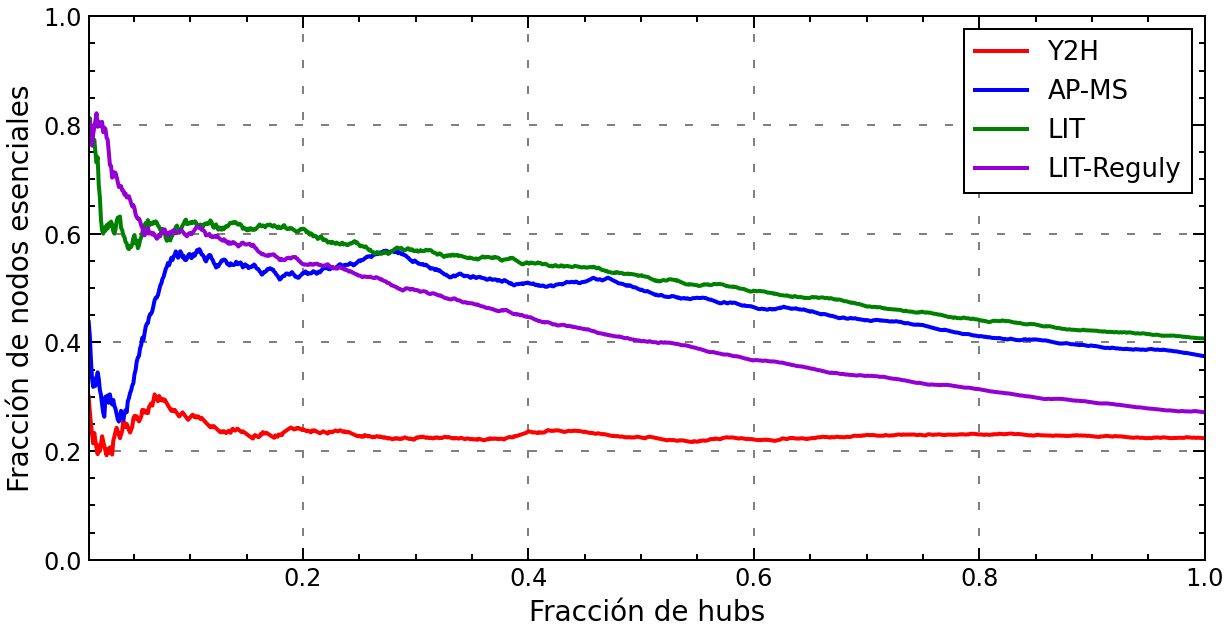

In [8]:
def ess_frac(G):
    """
    Calcula la fracción de nodos esenciales para distintas proporciones.
    """
    global ess_names
    
    #Init
    hubs_frac = np.linspace(0.01,1,1000)
    order_degree = ordered_degree_list(G)
    ess_hubs_frac = []
    
    for p in hubs_frac:
        hubs_amount = int(len(G.nodes())*p)
        ess_hubs = set(order_degree[:hubs_amount]).intersection(ess_names)
        ess_hubs_frac.append(len(ess_hubs)/hubs_amount) #esto es la cantidad de hubs que son esenciales
    
    return hubs_frac, ess_hubs_frac

hf_y2h, ehf_y2h = ess_frac(graph_y2h)
hf_apms, ehf_apms = ess_frac(graph_apms)
hf_lit, ehf_lit = ess_frac(graph_lit)
hf_litreg, ehf_litreg = ess_frac(graph_litreg)

fig, ax = plt.subplots(1, 1, figsize = (10,5))

ax.plot(hf_y2h, ehf_y2h, color = "red", label = "Y2H")
ax.plot(hf_apms, ehf_apms, color = "blue", label = "AP-MS")
ax.plot(hf_lit, ehf_lit, color = "green", label = "LIT")
ax.plot(hf_litreg, ehf_litreg, color = "darkviolet", label = "LIT-Reguly")
ax.set_xlim(0.01, 1)
ax.set_ylim(0, 1)
ax.set_ylabel("Fracción de nodos esenciales")
ax.set_xlabel("Fracción de hubs")
ax.legend()

plt.show()

## Figura 3: Tamaño de la componente principal al remover nodos según su centralidad

In [6]:
#Romper red
def break_network(G, remove_func, max_frac: float = 0.5):
    cg = giant_component(G)
    cg_size = len(cg.nodes())
    cg_frac = []
    removed_frac = []
    i = 1
    while i < cg_size*max_frac:
        # Tomamos el nodo a sacar usando la funcion pasada
        removing_node = remove_func(cg)
        # Lo sacamos
        cg.remove_node(removing_node)
        # Nos quedamos con la nueva componente gigante
        try:
            cg = giant_component(cg)
        except ValueError:
            break
        # Guardamos la fracción que queda (Es más util guardar el tamaño total y después ver que hacemos para normalizar).
        remaining_frac = len(cg.nodes()) #Tamaño actual
        cg_frac.append(remaining_frac)
        # Guardamos la fracción que ya sacamos
        removed_frac.append(i/cg_size) #Fracción de nodos que saque de la componente Princial / tamaño de la componente principal original.
        
        i+=1
        
    return removed_frac, cg_frac

#Guardado de objetos
def save_destruction(obj, filename):
    with open(filename, 'wb') as f:
        pickle.dump(obj, f)
        
#Carga de objetos
def load_destruction(filename):
    with open(filename, "rb") as f:
        dest = pickle.load(f)
    return dest

Primero calculamos tres centralidades y guardamos.

In [7]:
###Funciones para calcular centralidad
def max_degree_centrality(G):
  # Calcula la centralidad de grado
  centrality = nx.degree_centrality(G)
  # Devuelve el nodo de máxima centralidad
  return max(centrality, key = centrality.get)

def max_betweenness_centrality(G):
  # Calcula la centralidad de grado
  centrality = nx.betweenness_centrality(G)
  # Devuelve el nodo de máxima centralidad
  return max(centrality, key = centrality.get)

def max_closeness_centrality(G):
  # Calcula la centralidad de grado
  centrality = nx.closeness_centrality(G)
  # Devuelve el nodo de máxima centralidad
  return max(centrality, key = centrality.get)

# Tuve que subir la tolerancia de 1e-6 a 1e-3. No sé que tan malo será, pero sino no se ejecutaba.
def max_eigenvector_centrality(G):
  # Calcula la centralidad de grado
  centrality = nx.eigenvector_centrality(G, max_iter=100, tol=1e-03, nstart=None, weight='weight')
  # Devuelve el nodo de máxima centralidad
  return max(centrality, key = centrality.get)

centralities = {"Degree": max_degree_centrality, "Betweenness": max_betweenness_centrality, 
                "Closeness": max_closeness_centrality, "Eigenvector": max_eigenvector_centrality}

dest_dict = {} #Red1: {Centralidad1: valores, Centralidad2: valores...}
for name, graph in nets.items():
    vals = {}
    print(f"For {name}:")
    try:
        vals = load_destruction("dest"+name+".dict")
        print(f"{name} loaded.")

    except:
        for cent_name, func in centralities.items():
            print(f"\tDestroying using {cent_name}.")
            vals[cent_name] = break_network(graph, func)
        save_destruction(vals, "dest"+name+".dict")
        print(f"{name} saved.")
        
    finally:
        dest_dict[name] = vals

For Y2H:
Y2H loaded.
For AP-MS:
AP-MS loaded.
For LIT:
LIT loaded.
For LIT-Reguly:
LIT-Reguly loaded.


Agregamos la aleatoria por separado porque se corre rapido.

In [8]:
def random_node(G):
    from random import choice
    return choice(list(G.nodes))

centralities = {"Random": random_node}

dest_dict2 = {}
for name, graph in nets.items():
    vals = {}
    print(f"For {name}:")
    for cent_name, func in centralities.items():
        print(f"\tDestroying using {cent_name}.")
        vals[cent_name] = break_network(graph, func)
    dest_dict2[name] = vals

For Y2H:
	Destroying using Random.
For AP-MS:
	Destroying using Random.
For LIT:
	Destroying using Random.
For LIT-Reguly:
	Destroying using Random.


Normalización

In [25]:
dest_dict_u = {n: {**dest_dict[n], **dest_dict2[n]} for n in dest_dict.keys()}
dest_dict_u_copy = dest_dict_u.copy()

c_names = ["Degree", "Betweenness", "Closeness", "Eigenvector", "Random"]

for n in nets.keys():
    for c in c_names:
        dest_dict_u_copy[n][c] = list(dest_dict_u_copy[n][c]) 
        dest_dict_u_copy[n][c][1] = np.array(dest_dict_u[n][c][1])/len(list(giant_component(nets[n]).nodes()))

Calculamos los puntos del gráfico para los nodos esenciales

In [29]:
def get_ess_dot(G):
    """
    Consigue, para una dada red G, el tamaño de la componente gigante tras eliminar todos los nodos esenciales
    presentes en la misma, y la fracción de nodos eliminados en la red. 
    """
    global ess_names

    ### x: Eliminamos todos los esenciales. Que fracción de eliminados es?
    gc = giant_component(G)
    ess_nodes_in_net = [n for n in ess_names if n in list(gc.nodes())] #Nodos esenciales en la red.
    x_ess_dot = len(ess_nodes_in_net)/len(list(giant_component(nets[net_name]).nodes())) #Nodos eliminados / Nodos de la CG

    ### y: Que tamaño tiene la componente gigante tras eliminar todos los nodos esenciales?
    Gcopy = G.copy()

    cg_before = giant_component(Gcopy) #Componente gigante antes de eliminar los nodos esenciales.
    N_cg_before = len(list(cg_before.nodes()))

    Gcopy.remove_nodes_from(ess_names) #Eliminamos los nodos esenciales en la red.
   
    cg_after = giant_component(Gcopy) #Componente gigante despues de eliminar los nodos esenciales.
    N_cg_after = len(list(cg_after.nodes()))
    
    y_ess_dot = N_cg_after / N_cg_before #Tamaño CG despues / Tamaño CG antes
    
    return (x_ess_dot, y_ess_dot)

#Conseguimos el punto para cada red
ess_dots = {}
for net_name, net in nets.items():
    ess_dots[net_name] = get_ess_dot(net)

print(ess_dots)

{'Y2H': (0.2185792349726776, 0.6241651487553127), 'AP-MS': (0.4043824701195219, 0.3237051792828685), 'LIT': (0.4245671887881286, 0.281121187139324), 'LIT-Reguly': (0.2714019851116625, 0.5700992555831266)}


Finalmente graficamos

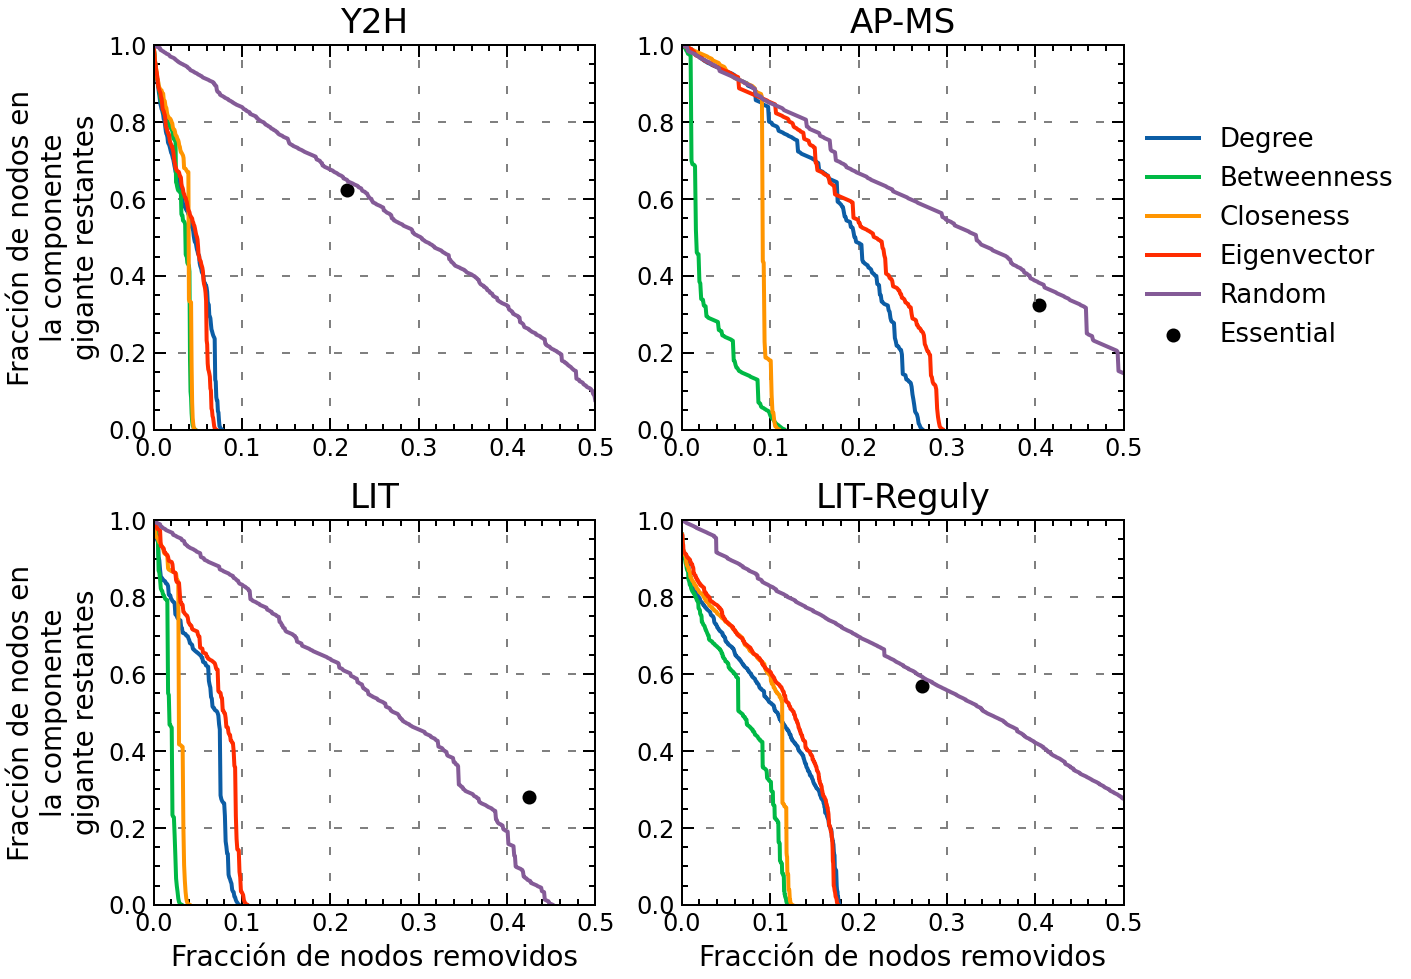

In [31]:
fig, ax = plt.subplots(2, 2, figsize = (10, 7), tight_layout = True)
ax = ax.flatten()

#Para cada red
for i, (net_name, net_dest_vals) in enumerate(dest_dict_u.items()): 
    #Para cada centralidad
    for cent_name, vals in net_dest_vals.items():
        #Al final no pedían Subgraph. La sacamos.
        if cent_name not in ("Subgraph"):
            ax[i].plot(vals[0], vals[1], label = cent_name)
        
    ax[i].set_title(net_name)
    ax[i].set_ylim(0, 1)
    ax[i].set_xlim(0, 0.5)
    
    x_ess_dot, y_ess_dot = ess_dots[net_name]
    ax[i].scatter(x_ess_dot, y_ess_dot, color = "black", label = "Essential")
    
ax[2].set_xlabel("Fracción de nodos removidos")
ax[3].set_xlabel("Fracción de nodos removidos")
ax[0].set_ylabel("Fracción de nodos en\nla componente\ngigante restantes")
ax[2].set_ylabel("Fracción de nodos en\nla componente\ngigante restantes")
ax[1].legend(bbox_to_anchor = (1, 0.5), loc = "center left", frameon = False)

plt.show()

## Figura 2b